# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. 

> Neural networks with non-linear activations work like **universal function approximators**. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

## 1. Gradient Descent

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## 2. Backpropagation

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once you learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/w1_backprop_graph.png' width=400px>

In the forward pass through the network, our data and operations go from right to left here. To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial \ell}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial \ell}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

> To train a neural network model:
> * We need to define a **loss function**, based on which the gradients are calculated. In PyTorch, you'll usually see this as `criterion`. 
> * We also need to define the **optimizer** that updates parameters of model aiming to optimize the loss between output and targets. 


## 3. Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. 

> It does this by keeping track of operations performed on tensors. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`. You can refer to the official document [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py) for more detail.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper

In [3]:
x = torch.randn(2,2, requires_grad=True)
print(type(x))
print(x)

<class 'torch.Tensor'>
tensor([[ 0.6050,  1.2721],
        [ 1.0154, -1.0892]])


In [5]:
y = x**2
print(y)

tensor([[ 0.3660,  1.6183],
        [ 1.0310,  1.1864]])


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [6]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autgrad module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [7]:
z = y.mean()
print(type(z))
print(z)

<class 'torch.Tensor'>
tensor(1.0504)


You can check the gradients for `x` and `y` but they are empty currently.

In [8]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient/derivative for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [9]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.3025,  0.6361],
        [ 0.5077, -0.5446]])
tensor([[ 0.3025,  0.6361],
        [ 0.5077, -0.5446]])


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step. 

## 4. Get the data and define the network

The same as we saw in part 3, we'll load the MNIST dataset and define our network.

In [10]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

I'll build a network with `nn.Sequential` here. Only difference from the last part is I'm not actually using softmax on the output, but instead just using the raw output from the last layer. This is because the output from softmax is a probability distribution. Often, the output will have values really close to zero or really close to one. Due to [inaccuracies with representing numbers as floating points](https://docs.python.org/3/tutorial/floatingpoint.html), computations with a softmax output can lose accuracy and become unstable. To get around this, we'll use the raw output, called the **logits**, to calculate the loss.

In [11]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('dropout1', nn.Dropout(p=0.5)),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('dropout2', nn.Dropout(p=0.5)),
                      ('logits', nn.Linear(hidden_sizes[1], output_size))]))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5)
  (logits): Linear(in_features=64, out_features=10, bias=True)
)


## 5. Training the network!

To train a neural network model, we need to define a **loss function**, based on which the gradients are calculated. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the **optimizer** that updates parameters aiming to optimize the loss between output and targets. We are using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`.

1. The first argument to `optim.SGD` is `model.parameters()`. The `parameters()` function of a `nn.Module` object returns its so called parameters (Implemented as  `nn.Parameter` objects. For now, we can think of it as a list of associated `Tensor`s which are **learnable**). `model.parameters()`  are basically the weights of our neural network.
2. The second argument is the learning rate.

In [12]:
# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

First, let's consider just one learning step before looping through all the data. 

> The general process with PyTorch:
> 1. Make a forward pass through the network `outputs = model.forward(x)` to get the outputs. 
> 2. Use the outputs and targets to calculate the `loss`.
> 3. Perform a backward pass through the network with `loss.backward()` to calculate the gradients.
> 4. Take a step with the optimizer by `optimizer.step()`. When step() is called, the optimizer updates each of the `Tensor` in `model.parameters()` using the gradient update rule equation. The gradients are accessed by using the `grad` attribute of each `Tensor`

Notice we call `optimizer.zero_grad()` before our forward pass. This is because a leaf `Tensor`s (which are weights are) will retain the gradients from previous passes. If `backward` is called again on the loss, the new gradients would simply be added to the earlier gradients contained by the `grad` attribute. This functionality comes handy when working with RNNs, but for now, we need to set the gradients to zero so the gradients don't accumulate between subsequent passes.

Below I'll go through one training step and print out the weights and gradients so you can see how it changes.

In [13]:
print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# 1. Forward pass, calculating the outputs, then update weights
# output = model.forward(images)
output = model(images)
# 2. Calculating the loss
loss = criterion(output, labels)
# 3. Backward pass, calculating the gradients of parameters (weights and biases)
loss.backward()
print('Gradient -', model.fc1.weight.grad)
# 4. Update parameters to optimize loss
optimizer.step()

Initial weights -  Parameter containing:
tensor([[-2.8903e-02,  3.3535e-02, -4.1149e-04,  ...,  3.5393e-02,
         -2.8318e-03,  2.0366e-02],
        [ 3.4137e-02, -1.7841e-02,  1.1134e-02,  ...,  3.0760e-02,
          1.9534e-02, -9.6798e-03],
        [-1.1106e-02,  1.2739e-02, -1.3318e-02,  ..., -6.0394e-03,
         -2.4955e-02, -6.2886e-03],
        ...,
        [ 1.4913e-02, -2.2833e-02, -3.1461e-02,  ..., -2.6845e-02,
          2.5601e-02,  9.0064e-03],
        [ 1.7695e-02, -2.0893e-02, -5.7543e-04,  ..., -2.4413e-02,
          1.4784e-02,  1.6340e-02],
        [-3.8643e-03,  1.3959e-02,  2.1669e-02,  ..., -3.4837e-03,
          2.3115e-03,  2.9686e-02]])
Gradient - tensor(1.00000e-02 *
       [[ 0.5998,  0.5998,  0.5998,  ...,  0.5998,  0.5998,  0.5998],
        [ 0.2439,  0.2439,  0.2439,  ...,  0.2439,  0.2439,  0.2439],
        [-0.3579, -0.3579, -0.3579,  ..., -0.3579, -0.3579, -0.3579],
        ...,
        [ 0.0500,  0.0500,  0.0500,  ...,  0.0500,  0.0500,  0.0500],
  

In [13]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[-1.5240e-02,  2.9884e-02, -5.9089e-04,  ...,  1.6167e-02,
         -1.7862e-02, -2.9152e-02],
        [ 9.1107e-03,  3.0220e-02, -3.7734e-03,  ...,  3.0422e-03,
         -1.0940e-02, -3.3390e-02],
        [-3.3786e-02, -1.5881e-02, -2.6266e-02,  ..., -1.1279e-02,
         -1.7492e-02, -2.0365e-02],
        ...,
        [-2.1368e-02, -8.1305e-03, -9.0169e-04,  ...,  5.6279e-03,
          1.1645e-02, -3.1481e-02],
        [ 3.3958e-02, -1.5449e-02, -1.6166e-02,  ...,  1.9903e-02,
         -2.3162e-02, -2.5192e-02],
        [ 2.6537e-02, -2.3568e-02, -2.0296e-02,  ...,  7.3372e-03,
         -6.5094e-03,  1.6915e-02]])


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. This is fairly straightforward. We'll loop through the mini-batches in our dataset, pass the data through the network to calculate the losses, get the gradients, then run the optimizer.

In [14]:
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [16]:
epochs = 1
print_every = 40
steps = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        ####### Forward and backward passes
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        #######
        
        # Accumulate loss
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/1...  Loss: 0.9930
Epoch: 1/1...  Loss: 0.9782
Epoch: 1/1...  Loss: 0.9291
Epoch: 1/1...  Loss: 0.9632
Epoch: 1/1...  Loss: 0.9564
Epoch: 1/1...  Loss: 0.9425
Epoch: 1/1...  Loss: 0.9165
Epoch: 1/1...  Loss: 0.9243
Epoch: 1/1...  Loss: 0.9395
Epoch: 1/1...  Loss: 0.9285
Epoch: 1/1...  Loss: 0.9312
Epoch: 1/1...  Loss: 0.8886
Epoch: 1/1...  Loss: 0.8787
Epoch: 1/1...  Loss: 0.9208
Epoch: 1/1...  Loss: 0.8962
Epoch: 1/1...  Loss: 0.8801
Epoch: 1/1...  Loss: 0.8965
Epoch: 1/1...  Loss: 0.8645
Epoch: 1/1...  Loss: 0.8502
Epoch: 1/1...  Loss: 0.8207
Epoch: 1/1...  Loss: 0.8708
Epoch: 1/1...  Loss: 0.8459
Epoch: 1/1...  Loss: 0.8341


With the network trained, we can check out it's predictions. We put our evaluation code inside `torch.no_grad` context, so that no graph is created for evaluation. 

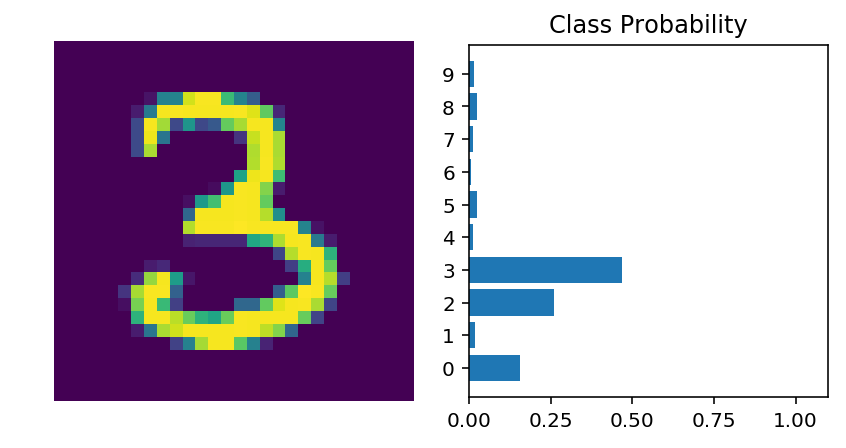

In [17]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)

Now our network is brilliant. It can accurately predict the digits in our images. Next up you'll write the code for training a neural network on a more complex dataset.